In [1]:
subj = 'UI399'
root_dir = '/Users/alia/Documents/mandarin'

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join, exists
from os import makedirs
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from sklearn.preprocessing import scale
import random
import librosa
from scipy import stats
from scipy.signal import hilbert, chirp
import peakutils
import plotly
plotly.tools.set_credentials_file(username='ashafi', api_key='PxONlbVA45fzeK3YWWb9')
from plotly.offline import iplot, init_notebook_mode
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import peakutils
import plotly.graph_objs as go
import matplotlib.pyplot as plt

/Users/alia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Create directories
fdir = root_dir + '/mandarin_ffr/fig/' + subj
odir = root_dir + '/output/' + subj

if not exists(fdir):
    makedirs(fdir)
if not exists(odir):
    makedirs(odir)

In [4]:
# Where are the data?
dir_data = ''.join([root_dir, '/', subj, '/data'])
file_ECoG = ''.join([dir_data, '/', subj, '_dat_clicks_block_8.mat'])
# file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR.mat'])

# Load the .mat file
f = h5py.File(file_ECoG, 'r')

# Read ECoG data
hg_stim = np.array(f['dat']['lfp']) # trial * tp * ch
time_axis = (np.round(f['dat']['time_axis'].value.flatten(), 3) * 1000).astype(int) # Use int b/c float precision



# Import behav
behav = np.array(f['dat']['behav'])
    
f.close()

In [5]:
a = np.where(behav[1] == 100)
a[0].shape

(50,)

In [6]:
myidx = np.where(behav[1] ==100)
myhg = np.mean(hg_stim[myidx[0], :, 14], axis = 0)

In [7]:
def get_peaks(myhg):
    '''finds the peaks for a given data set and plots a graph'''
    myhg= abs(myhg)
    time_series = myhg[(time_axis >= 500) & (time_axis <= 600)]
    cb = np.array(time_series)
    indices = peakutils.indexes(cb, thres=0.02/max(cb), min_dist=0.1)

    trace = go.Scatter(
        x=[j for j in range(len(time_series))],
        y=time_series,
        mode='lines',
        name='Original Plot'
    )

    trace2 = go.Scatter(
        x=indices,
        y=[time_series[j] for j in indices],
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(255,0,0)',
            symbol='cross'
        ),
        name='Detected Peaks'
    )
    data = [trace, trace2]
    return trace2

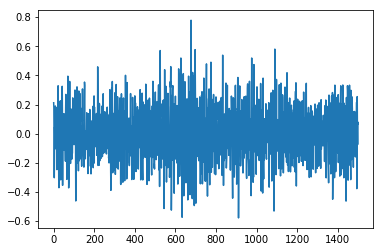

In [8]:
plt.plot(myhg)
plt.show()

/Users/alia/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



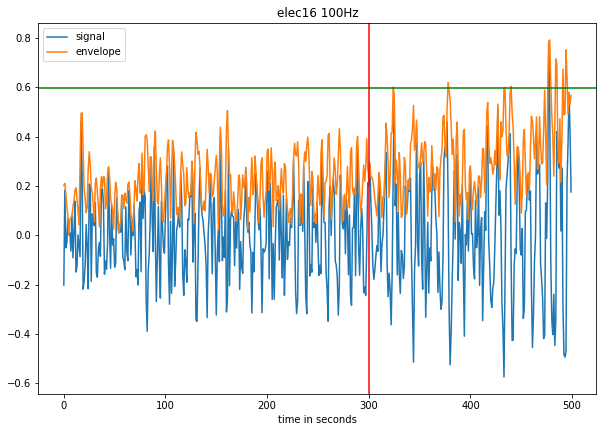

In [9]:
test = hilbert(myhg)
h = get_peaks(test)
peaks =np.percentile(h['y'], 99)


fs = 100
duration = 500
samples = int(fs*duration)
t = np.arange(samples/fs)
amplitude_envelope = np.abs(test[200:700])
instantaneous_phase = np.unwrap(np.angle(test[200:700]))
instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)



#plot                               
fig = plt.figure(figsize = (10,15))
ax0 = fig.add_subplot(211)
ax0.plot(t, test[200:700], label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()





plt.axhline(y=peaks, color = 'g')
plt.axvline(x = 300, color = 'r')
plt.title('elec16 100Hz')
plt.plot()
plt.show()

In [10]:
def hilb_delay(elec,fq):
    '''runs hilb transform on pre vs post stim'''

    ## set time to pre or post

    ##set index to elec and fq
    myidx = np.where(behav[1] == fq)
    myhg = np.mean(hg_stim[myidx[0], :, elec], axis = 0)


    #get hilb transform
    test = hilbert(myhg)

    # get amps
    fs = 100
    duration = 300
    samples = int(fs*duration)
    t = np.arange(samples/fs)
    amplitude_envelope = np.abs(test[200:500])
    instantaneous_phase = np.unwrap(np.angle(test[200:500]))
    instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)



    #get delay                                  
    fig = plt.figure(figsize = (10,15))
    ax0 = fig.add_subplot(211)
    ax0.plot(t, test[200:500], label='signal')
    ax0.plot(t, amplitude_envelope, label='envelope')
    ax0.set_xlabel("time in seconds")
    ax0.legend()
    plt.show()

    return test

/Users/alia/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



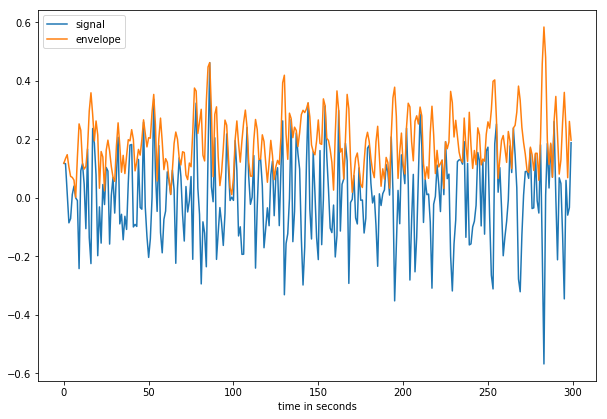

[]

In [11]:
hilb_delay(15,100)
plt.plot()

In [12]:
#get peaks
peaks = get_peaks(test)
avg = sum(peaks['y'])/len(peaks['y'])   

In [13]:
np.arange(samples)/100

array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 4.9997e+02, 4.9998e+02,
       4.9999e+02])

In [14]:
from numpy.fft import ifft, fft

# HILBERT TRANSFORM
def filt_hilbert(signal,fs,filt_fun,filt_args):
    """
    Filters the signals with the specified filter, and performs a hilbert transform

    Parameters:

    signal (1-D np.array)
    fs: frequency of signal
    filter_center in Hz
    filter_std in Hz

    Return: bandpassed complex hilbert signal
    """

    n, = signal.shape
    #print(n)
    #print(n/2)
    # set up hilbert part
    h = np.zeros((n,))
    h[0] = 1
    if n%2==0:
        # n is even
        h[1:int(n/2)] = 2
        h[int(n/2)] = 1
    else:
        # n is odd
        #print(int(round(n+1)/2))
        h[1:int(round(n+1)/2)] = 2

    # set up band-pass part
    xf = np.linspace(0.0, fs / 2.0, n/2)
    bandpass = filt_fun(xf,filt_args)

    return ifft(bandpass*h*fft(signal))


# Create gaussian filter
def gen_gauss_filt(xf, xxx_todo_changeme):
    (cf,sigma_fs) = xxx_todo_changeme
    filt = np.exp(-0.5*(((xf - cf)/(sigma_fs*np.sqrt(2)))**2))
    return np.concatenate([filt,np.flipud(filt)])

In [20]:
######## setup bandpass hilbert filter parameters
#default:
fq_min = 4.
fq_max = 200.
scale_factor = 7.
a=[np.log10(.39), .5]

cfs = 2**(np.arange(np.log2(fq_min)*scale_factor,np.log2(fq_max)*scale_factor)/scale_factor)
sigma_fs=-a[0] * cfs**a[1]

# Convert the data into a numpy array
# Cut out the last sampling point if odd-numbered ... that's the final 2.5 ms
rawdata = np.array(iidata_ds)[0:(int(iidata_ds.shape[0] / 2) * 2), :]

# Empty numpy array for hilbert
hdata = np.zeros((rawdata.shape[0], rawdata.shape[1], len(cfs)))

# Go through each channel for Hilbert transformation ... 20-25 seconds for each channel
for chan in range(0, iidata_ds.shape[1]):

    chan_start = time.time()

    print(''.join(['Starting channel ', str(chan), ' ...']))

    # Input channel
    ivec = rawdata[:, chan]

    # Perform Hilbert for each center frequency
    for ifilt,filt_params in enumerate(zip(cfs, sigma_fs)):

        ihilb = abs(filt_hilbert(ivec, new_fs, gen_gauss_filt, filt_params))
        hdata[:, chan, ifilt] = ihilb

    chan_end = time.time()

    print(''.join(['Finished channel ', str(chan), ': ', str(chan_end - chan_start), ' seconds!']))

if read_flag >= 2: #
    # Average thru hilbert bands
    list_band = ['Theta', 'Alpha', 'Beta', 'LG', 'HG']
    dict_range = {'Theta': [4, 8], 'Alpha': [8, 13], 'Beta': [15, 25], 'LG': [35, 50], 'HG': [70, 150]}
    bhdata = np.zeros((hdata.shape[0], hdata.shape[1], len(list_band)))

    # Each band may take 600-1200 seconds across all channels
    for iter_band in list_band:
        print(iter_band)
        start_band = time.time()
        iter_range = dict_range.get(iter_band)
        index_cfs = ((cfs >= iter_range[0]) & (cfs < iter_range[1]))
        bhdata[:, :, list_band.index(iter_band)] = np.mean(hdata[:, :, index_cfs], axis = 2)
        end_band = time.time()
        print(str(end_band - start_band))

NameError: name 'iidata_ds' is not defined

In [15]:
fq_min = 4.
fq_max = 200.
scale_factor = 7.
a=[np.log10(.39), .5]

cfs = 2**(np.arange(np.log2(fq_min)*scale_factor,np.log2(fq_max)*scale_factor)/scale_factor)
sigma_fs=-a[0] * cfs**a[1]



In [16]:
cfs = np.array([100,125,150,200])

In [17]:
sigma_fs=-a[0] * cfs**a[1]

0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 

/Users/alia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



(100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (125, 4.572036685471688)
2 (150, 5.008415252747992)
3 (200, 5.783219788774961)
0 (100, 4.089353929735008)
1 (

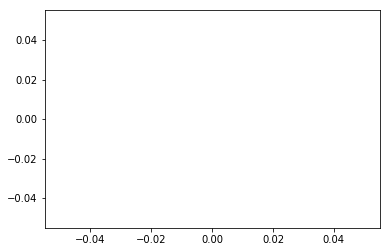

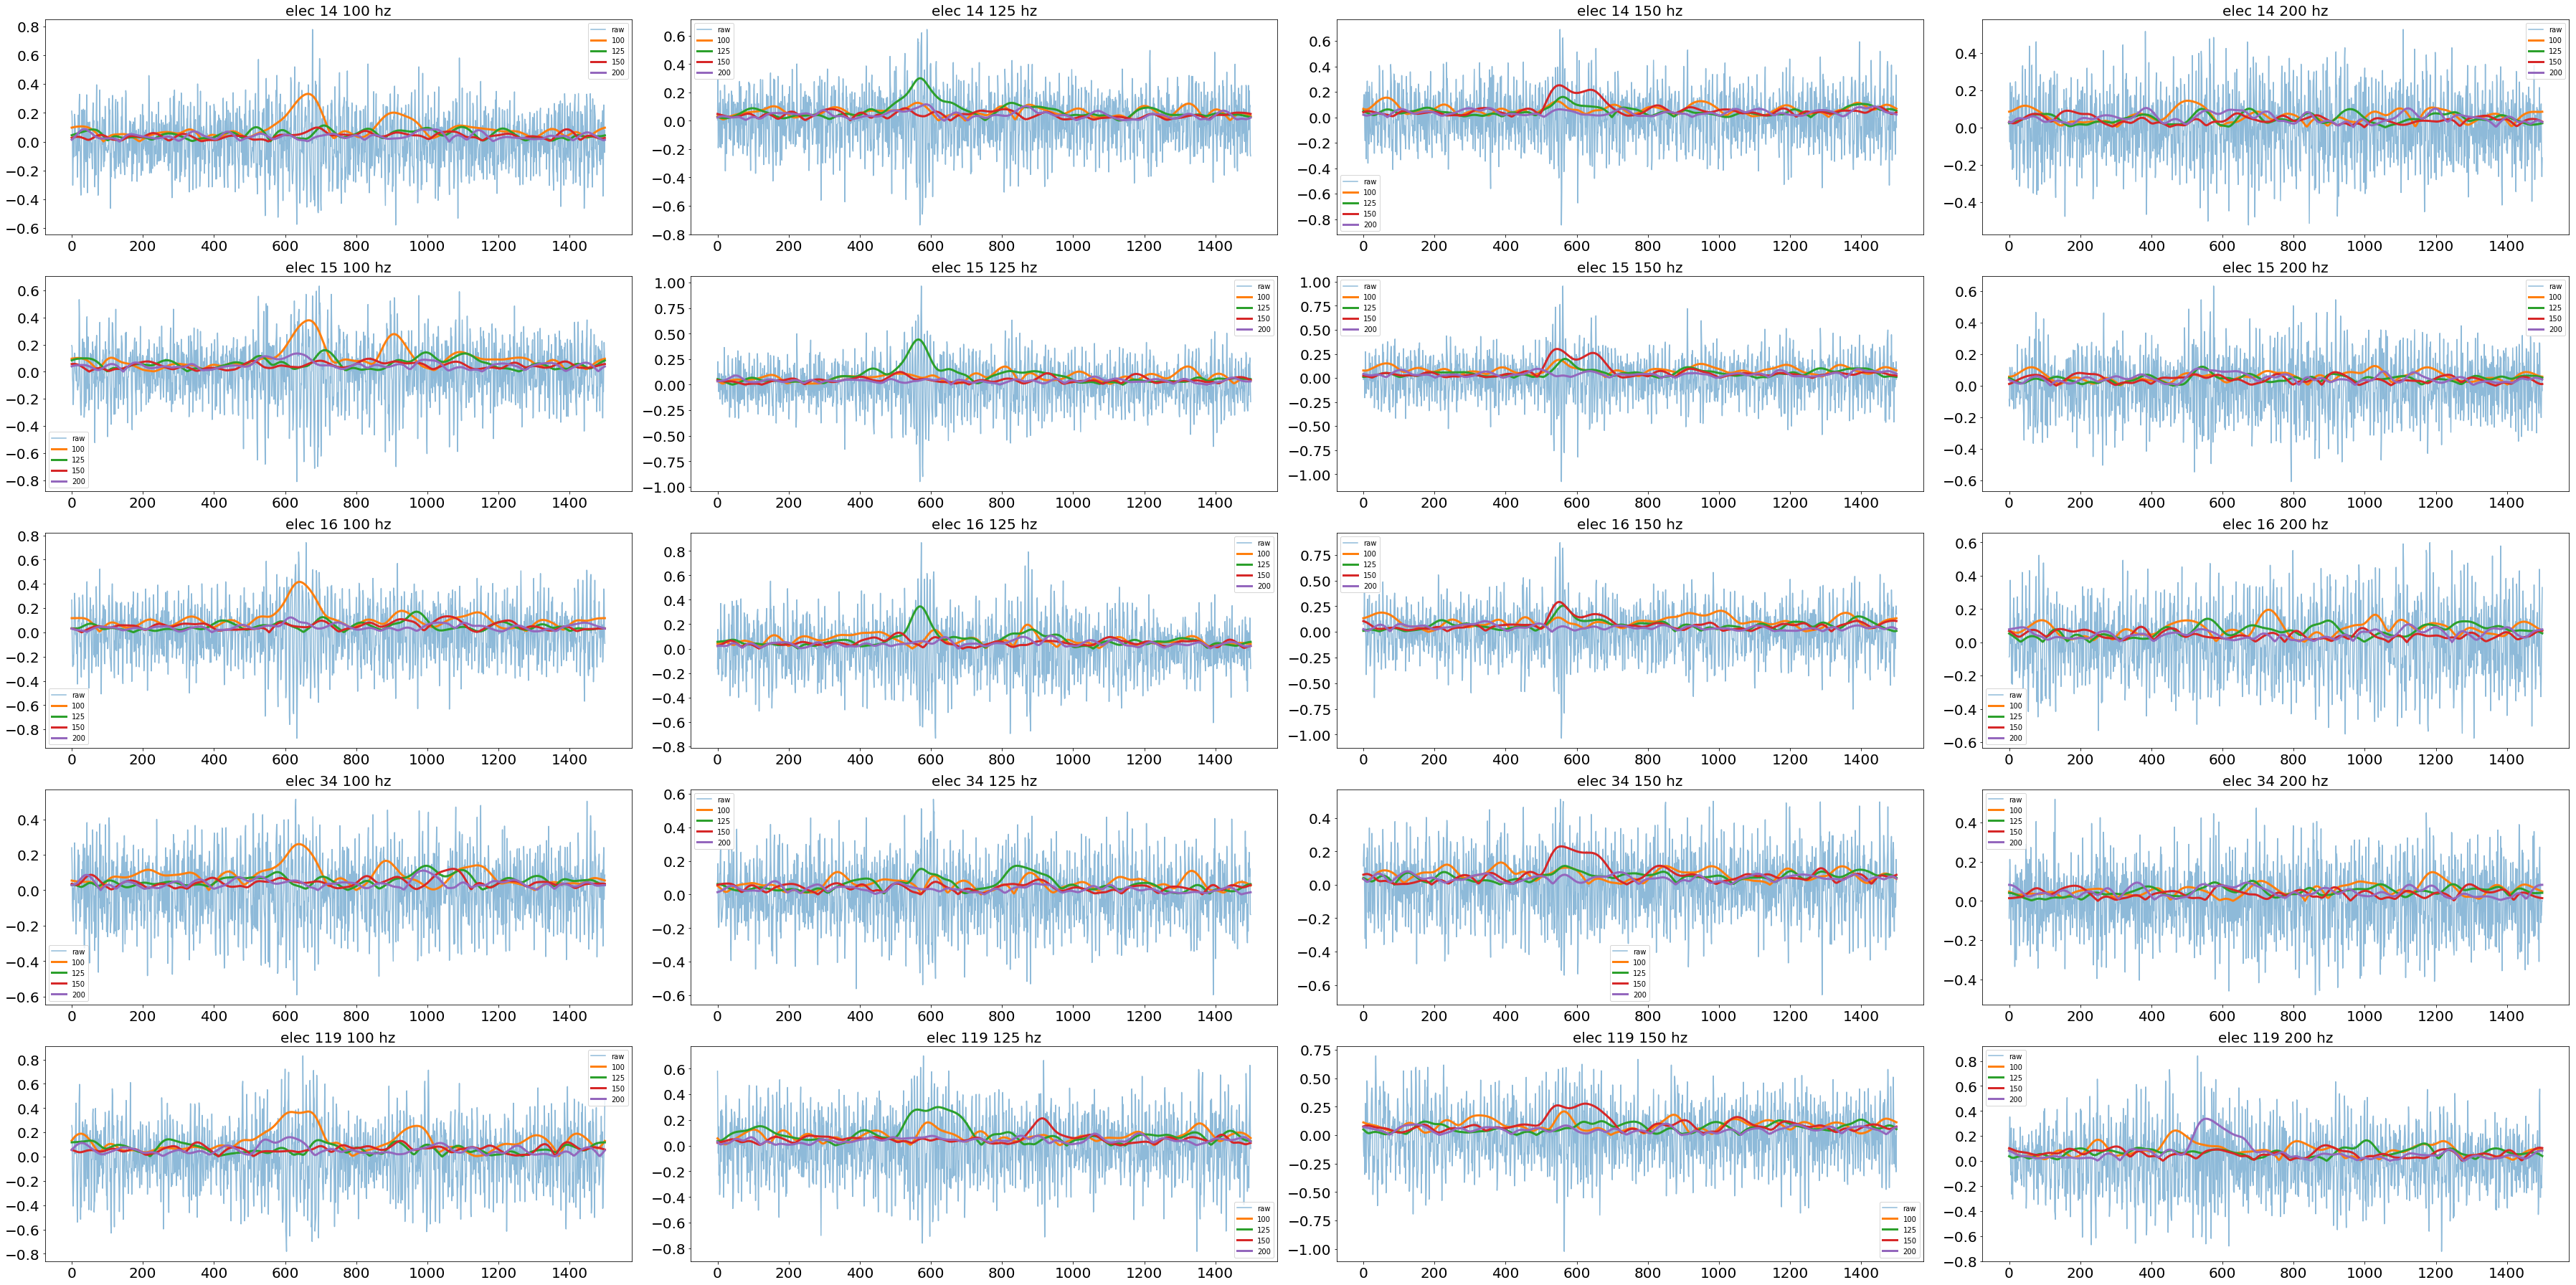

In [18]:
elecs = [14,15,16,34,119]
freq = [100,125,150,200]
iterplot=1
figure = plt.figure(figsize = (50,25))
info = pd.DataFrame()
liste = []
listf = []
listfilt = []
listclick = []
for elec in elecs:
    for fq in freq:
        myidx = np.where(behav[1] ==fq)
        myhg = np.mean(hg_stim[myidx[0], :, elec], axis = 0)

        ivec = myhg[:(int(len(myhg)/2) *2)]
        plt.subplot(5,4,iterplot)
        plt.plot(ivec, alpha = 0.5)

        for ifilt,filt_params in enumerate(zip(cfs, sigma_fs)):

            print(ifilt,filt_params)
            listfilt.append(filt_params[1])
            listf.append(filt_params[0])
            listclick.append(fq)
            liste.append(elec)


            ihilb = abs(filt_hilbert(ivec, 1000., gen_gauss_filt, filt_params))
            plt.plot(ihilb,lw = 3)
            plt.title('elec '+str(elec) + ' ' + str(fq) +' hz', size = 20)
            plt.legend(['raw',100,125,150,200])
            plt.xticks(size = 20)
            plt.yticks(size = 20)
        iterplot+=1
plt.tight_layout()
plt.show()

In [20]:
info['hz'] = listf
info['elec'] = liste
info['filt'] = listfilt
info['click'] = listclick

In [21]:
np.where(info['hz'] == info['click'])

(array([ 0,  5, 10, 15, 16, 21, 26, 31, 32, 37, 42, 47, 48, 53, 58, 63, 64,
        69, 74, 79]),)

281


/Users/alia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



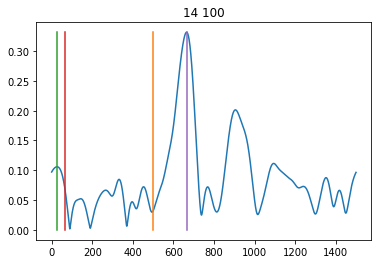

199


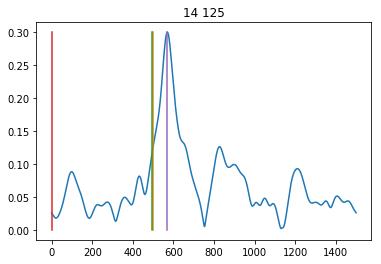

259


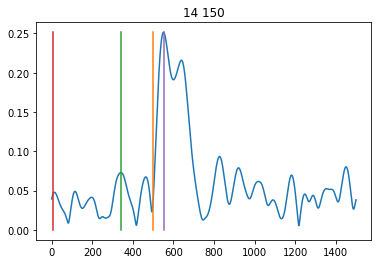

0


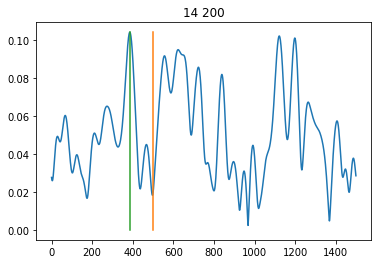

259


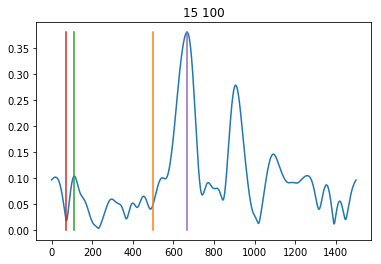

112


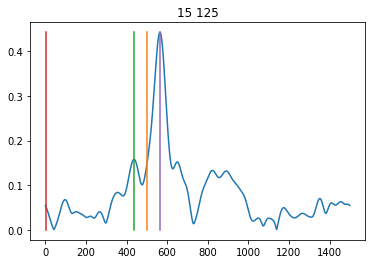

271


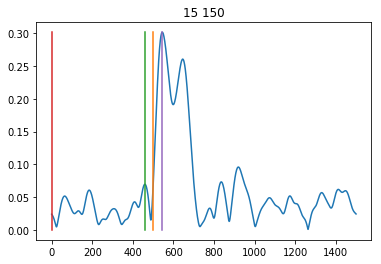

173


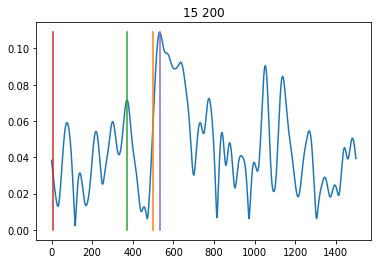

232


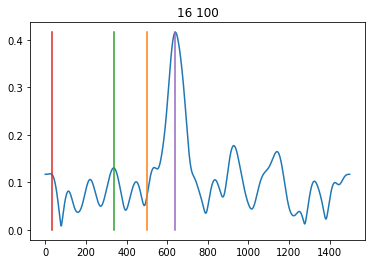

307


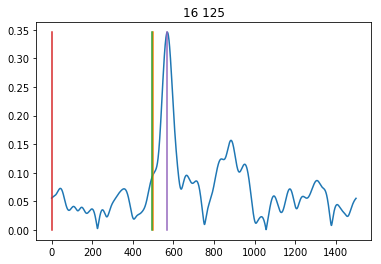

188


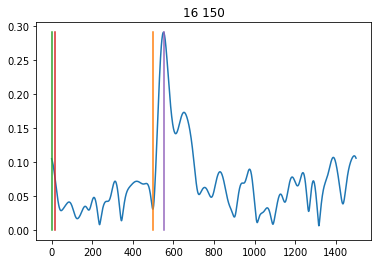

0


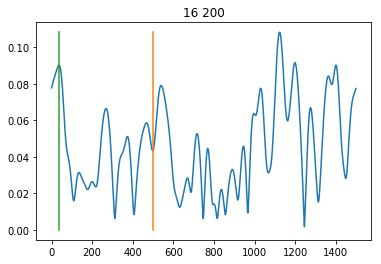

207


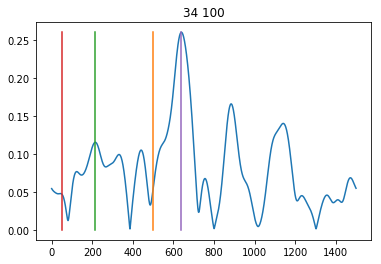

228


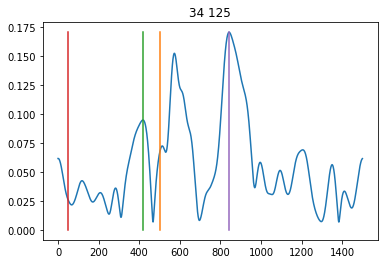

259


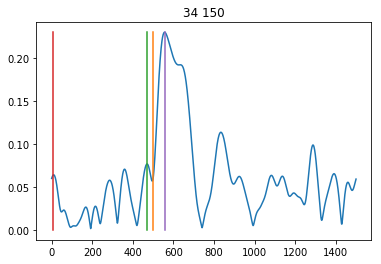

7


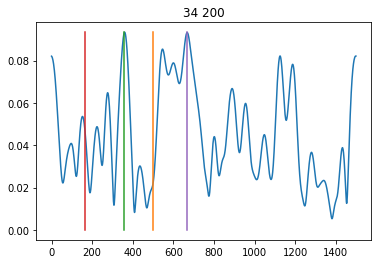

247


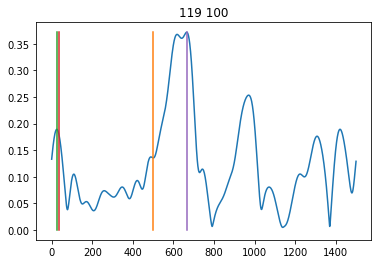

184


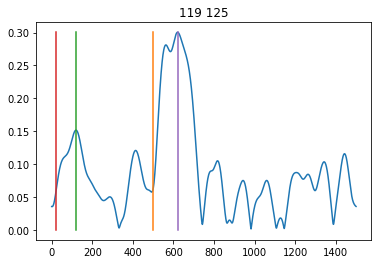

282


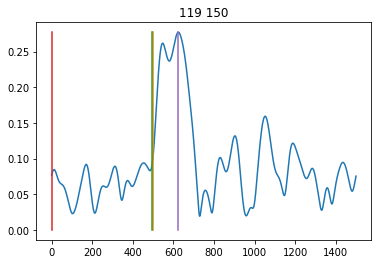

183


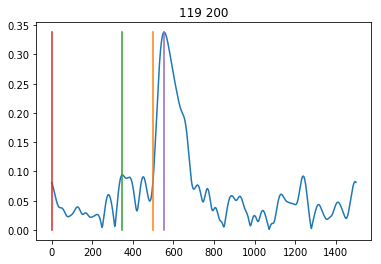

,elecs,click,delay_start_range,delay_end_range
0,14,100,65,[165]
1,14,125,1,[70]
2,14,150,8,[51]
3,14,200,0,[123]
4,15,100,71,[167]
5,15,125,5,[65]
6,15,150,1,[45]
7,15,200,7,[33]
8,16,100,33,[140]
9,16,125,1,[70]


In [22]:
delays = []
e = []
f = []
latest = []
data = pd.DataFrame()
for i in range(len(info['filt'])):
    if info['hz'][i] == info['click'][i]:
        myidx = np.where(behav[1] ==info['hz'][i])
        myhg = np.mean(hg_stim[myidx[0], :, info['elec'][i]], axis = 0)

        ivec = myhg[:(int(len(myhg)/2) *2)]
        ihilb = abs(filt_hilbert(ivec, 1000., gen_gauss_filt, (info['hz'][i],info['filt'][i])))
        pre = ihilb[0:500]
        post = ihilb[500:1000]
        prePeak = np.percentile(pre, 99)
        test = np.where(pre > prePeak)
        test2 = np.where(post >prePeak)
        plt.plot(ihilb)
        plt.plot([500,500],[0,np.max(ihilb)])
        plt.plot([test[0][1],test[0][1]],[0,np.max(ihilb)])
        ma = 500 + np.where(post == max(post))[0]
        latest.append(ma-500)
        print(len(test2[0]))
        if len(test2[0]) != 0:
            plt.plot([test2[0][1],test2[0][1]],[0,np.max(ihilb)])
            plt.plot([ma,ma],[0,np.max(ihilb)])
        if len(test2[0])>0:
            a = test2[0][1]
            delays.append(a)
        else:
            delays.append(0)

        plt.title(str(info['elec'][i])+' ' +str(info['click'][i]))
        e.append(info['elec'][i])
        f.append(info['click'][i])
        plt.show()
data['elecs'] = e
data['click'] = f
data['delay_start_range'] = delays
data['delay_end_range'] = latest
data

In [34]:
t = [1,2,3]
if not t:
    print(t)

In [24]:
data.to_csv('delay_range.csv')

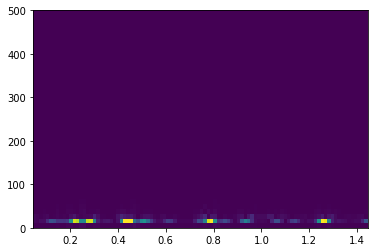

In [65]:
ihilb = abs(filt_hilbert(ivec, 1000., gen_gauss_filt, (100, 4.0893539297350081)))
f,t, Sxx = signal.spectrogram(ihilb, 1000, noverlap = 76, nperseg =90)
plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
plt.show()

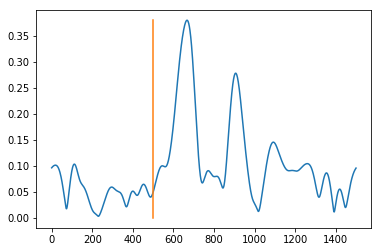

In [103]:
plt.plot(ihilb)
plt.plot([500,500],[0,np.max(ihilb)])
plt.show()

In [104]:
np.where(ihilb == np.max(ihilb))[0]

array([667])